In [2]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from scipy import signal
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize, StandardScaler
from itertools import combinations
from tqdm.notebook import tqdm
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')

# Groud truth

In [13]:
df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')

# np.mean(gt['h'])

# thold = 3.5
gt['lh'] = (gt[['h']] > np.mean(gt['h'])) * 1
gt['le'] = (gt[['e']] > np.mean(gt['e'])) * 1
gt['lx'] = (gt[['x']] > np.mean(gt['x'])) * 1
gt['la'] = (gt[['a']] > np.mean(gt['a'])) * 1
gt['lc'] = (gt[['c']] > np.mean(gt['c'])) * 1
gt['lo'] = (gt[['o']] > np.mean(gt['o'])) * 1
gt

,h,e,x,a,c,o,lh,le,lx,la,lc,lo
id,,,,,,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,1,0,0,0,1,0
3,3.38,3.44,3.50,3.50,4.50,3.81,0,0,1,1,1,1
4,3.19,3.75,3.69,3.19,2.63,2.63,0,1,1,1,0,0
5,3.25,3.63,2.13,3.56,3.63,2.31,0,1,0,1,1,0
6,3.25,2.75,3.50,2.50,3.75,5.00,0,0,1,0,1,1
7,4.06,3.06,3.38,2.88,2.50,4.19,1,0,1,0,0,1
8,3.94,2.94,3.19,3.75,3.38,3.81,1,0,1,1,1,1
9,4.44,4.00,3.38,3.75,3.69,3.31,1,1,1,1,1,0
10,3.63,3.25,3.50,3.31,3.88,2.69,1,0,1,1,1,0


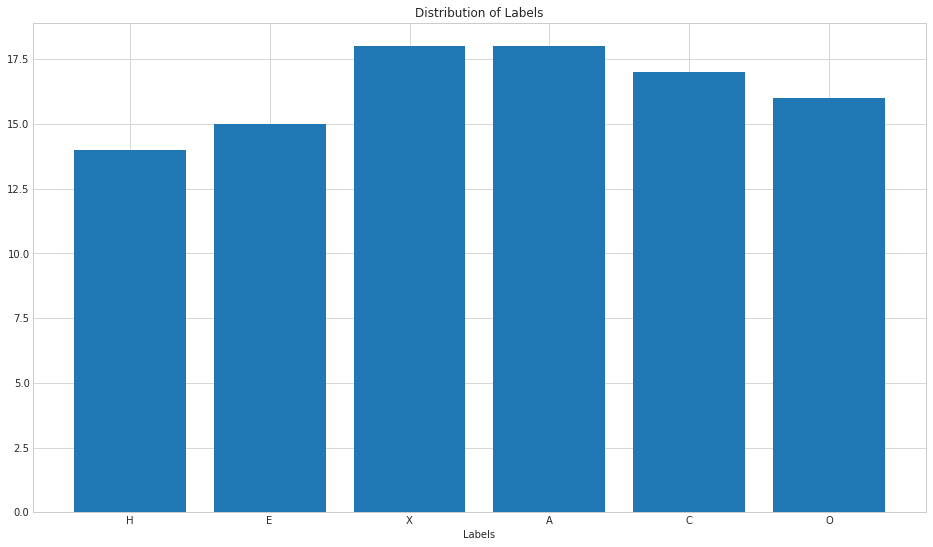

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# EEG data

In [15]:
def load_data():
    path, folders, filenames = next(walk('./data'))

    filenames.remove('11-audio.csv')
    filenames.remove('11-image.csv')

    filenames.remove('36-audio.csv')
    filenames.remove('36-image.csv')

    path = './data'
    columns = {'Unnamed: 1':'Fp1',
            'Unnamed: 2':'Fp2',
            'Unnamed: 3':'F3',
            'Unnamed: 4':'F4',
            'Unnamed: 5':'F7',
            'Unnamed: 6':'F8',
            'Unnamed: 7':'P7',
            'Unnamed: 8':'P8'}

    EEG_audio, EEG_image = dict(), dict()
    from itertools import product
    categories = [1,2,3,4,5]
    blocks = [1,2]
    with tqdm(filenames) as t:
        for filename in t:
            t.set_description(f"{filename}")
            participant_id, stimuli = filename.split('-')
            stimuli = stimuli.rstrip('.csv')
            data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
            # Aviod warning on stim has negative value
            marker = np.array(data['Marker'])
            marker[marker == '-1'] = '1'
            data['Marker'] = marker

            if(stimuli == 'audio'):
                EEG_audio[int(participant_id)] = data
            elif(stimuli == 'image'):
                EEG_image[int(participant_id)] = data
            else:
                raise ValueError(f"Stimuli:{stimuli} is unexpected.")
    return EEG_audio, EEG_image


In [16]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data()
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')

Load data from cache


# Pre process with PSD + log

In [17]:
def build_data(p_num, EEG,ids):
    X = None
    Y = None
    # Delta, Theta, Alpha, Beta, Gamma
    filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
    with tqdm(ids) as t:
        for index, id in enumerate(t):
            t.set_description(f"{id}")
            print(f"p_no={p_num}|index={index}|id={id}")
            raw = dataframe_to_raw(EEG[id], sfreq=250)
            
            # Preprocess
            raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
            raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
            events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
            events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0) # break
            # Check data
            if(events.shape[0] != 50):
                raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
            epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
            if(epochs.get_data().shape[0] != 50):
                raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

            # Extract features
            powers,freq = mne.time_frequency.psd_welch(epochs,n_fft = 250, verbose=False)
            features = np.mean(powers, axis=1)
            # print(features.shape) #(50,8,65)
            for e in range(features.shape[0]):
                row = np.expand_dims(features[e].reshape(-1), axis=0)
                row = 10 * np.log10(row)
                if(type(X) == type(None)): X = row
                else: X = np.concatenate( [X, row ], axis=0 )

                label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
                label = np.expand_dims(label, axis=0)
                if(type(Y) == type(None)): Y = label
                else: Y = np.concatenate( [Y, label ], axis=0 )

    print(f"{p_num} done| {ids}")
    return np.array(X),np.array(y)

In [ ]:
try:
    # [33,2,10,12,16]
    t_out = 100
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::6]])
    p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::6]])
    p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::6]])
    p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
    p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
    p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    ans2 = p2.get(timeout=t_out)
    ans3 = p3.get(timeout=t_out)
    ans4 = p4.get(timeout=t_out)
    ans5 = p5.get(timeout=t_out)
    ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0] , ans2[0], ans3[0], ans4[0] ,ans5[0], ans6[0]])
    y = np.concatenate([ans1[1] , ans2[1], ans3[1], ans4[1] ,ans5[1], ans6[1]])
    print(X.shape, y.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()